# Electrocardiography signal classification notebook
### Challenge: differentiate between normal and abnormal signal
Dealing with not balanced dataset (more normal signals than other types), signal and annotations in the form of numpy arrays

Taken approaches:
* deep neural networks
* decion trees
* support vector machines

# Download data

In [1]:
import os
import numpy as np

# install PhysioNet ecg data package 
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['bhx-brain-bounding-box',
  'Brain Hemorrhage Extended (BHX): Bounding box extrapolation from thick to thin slice CT images'],
 ['bidmc', 'BIDMC PPG and Respiration Dataset'],
 ['bigideaslab-step-hr-smartwatch',
  'BigIdeasLab_STEP: Heart rate measurements captured by smartwatches for differing skin tones'],
 ['body-sway-music-vr',
  'Body Sway When Standing and Listening to Music Modified to Reinforce Virtual Reality Environment Motion'],
 ['bpssrat', 'Blood Pressure in Salt-Sensitive Dahl Rats'],
 ['but-pdb',
  'Brno University of Technology E

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [3]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-64,position+64] window
    beats = np.zeros((len(annotations.sample),time_window*2))
    # note that we remove first and last beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove few first and last annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...851...file
...processing...883...file
...processing...876...file
...processing...849...file
...processing...865...file
...processing...861...file
...processing...801...file
...processing...829...file
...processing...885...file
...processing...858...file
...processing...873...file
...processing...850...file
...processing...880...file
...processing...843...file
...processing...802...file
...processing...857...file
...processing...820...file
...processing...894...file
...processing...826...file
...processing...846...file
...processing...864...file
...processing...877...file
...processing...806...file
...processing...892...file
...processing...804...file
...processing...854...file
...processing...879...file
...processing...891...file
...processing...871...file
...processing...823...file
...processing...809...file
...processing...822...file
...processing...812...file
...processing...868...file
...processing...845...file
...processing...884...file
...processing...875...file
.

Data is not balanced, much more normal beats are present than other types of signals.

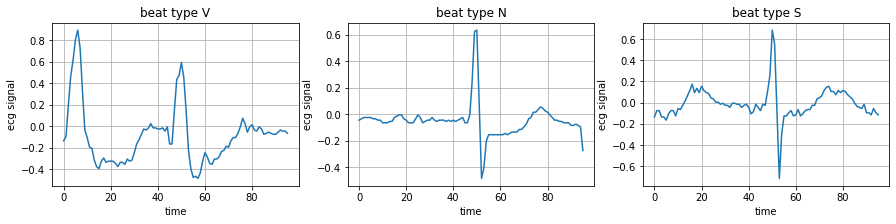

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
sample_number = [200,298,100]

for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

## Data form

In [ ]:
all_beats

array([[ 0.055,  0.095,  0.125, ...,  0.005, -0.015,  0.005],
       [ 0.025,  0.065,  0.025, ...,  0.035, -0.035, -0.035],
       [ 0.105,  0.085,  0.065, ..., -0.055, -0.065, -0.075],
       ...,
       [ 0.005,  0.005,  0.005, ..., -0.005, -0.015, -0.025],
       [ 0.085,  0.055,  0.045, ..., -0.155, -0.155, -0.145],
       [-0.145, -0.145, -0.145, ..., -0.005,  0.005,  0.015]])

In [ ]:
all_annotations

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

# Models based on manual signal features extraction






In [4]:
!git clone https://github.com/raphaelvallat/entropy.git entropy/
%cd entropy/
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'entropy'...
remote: Enumerating objects: 1487, done.
remote: Counting objects: 100% (476/476), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 1487 (delta 309), reused 354 (delta 197), pack-reused 1011
Receiving objects: 100% (1487/1487), 3.48 MiB | 23.93 MiB/s, done.
Resolving deltas: 100% (924/924), done.
/content/entropy
     |████████████████████████████████| 51kB 2.7MB/s 
running develop
running egg_info
creating entropy.egg-info
writing entropy.egg-info/PKG-INFO
writing dependency_links to entropy.egg-info/dependency_links.txt
writing top-level names to entropy.egg-info/top_level.txt
writing manifest file 'entropy.egg-info/SOURCES.txt'
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
reading manifest template 'MANIFEST.in'
writing manifest file 'entropy.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/entropy.egg-link (link to .)
Adding entropy 0.1.3 to easy-install.pth file

Installed /conte

In [32]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training 
# we take only some part of the whole dataset
X, y = all_beats[::5], all_annotations[::5]

# train/validation/test set splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_test))#, len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
#X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')    
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a 

25718 5512


In [ ]:
dicti = {"N":0, "S":0, "V":0}
for i in y_train:
  dicti[i]+=1
print(dicti)

{'N': 22721, 'S': 1639, 'V': 1358}


In [6]:
!pip install tsfresh

     |████████████████████████████████| 102kB 4.1MB/s 
     |████████████████████████████████| 102kB 4.4MB/s 
     |████████████████████████████████| 706kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 16.2MB/s 
     |████████████████████████████████| 112kB 39.7MB/s 
     |████████████████████████████████| 1.3MB 12.1MB/s 
ERROR: googleapis-common-protos 1.53.0 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.
ERROR: google-api-core 1.26.3 has requirement protobuf>=3.12.0, but you'll have protobuf 3.11.2 which is incompatible.
ERROR: distributed 2021.4.1 has requirement dask>=2021.03.0, but you'll have dask 2.12.0 which is incompatible.
  Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3
  Found existing installation: protob

In [8]:
!pip install scipy --upgrade scipy

     |████████████████████████████████| 27.4MB 135kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!pip list -v | grep scipy

scipy                         1.6.3          /usr/local/lib/python3.7/dist-packages pip      


In [33]:
from scipy.signal import argrelmin
import scipy.signal
from scipy.stats import entropy
import scipy.stats
import pandas as pd
import entropy as ent
import stochastic.processes.noise as sn
import tsfresh

def features_vector_creation(X):
  feature_vector = []
  for i in X:
    maxi = i.max()
    mini = i.min()
    med = np.median(i)

    p_data = pd.DataFrame(i).value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data) 

    E = np.sum(i ** 2)
    Xk = np.fft.fft(i)
    N = len(i)
    E_fft = np.sum(np.abs(Xk) ** 2) / N

    shannon = ent.spectral_entropy(i, sf=100, method='welch')

    zero_cross = ent.num_zerocross(i)

    svd_entropy = ent.svd_entropy(i, order=2)

    sum = tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(i)
    #auto = tsfresh.feature_extraction.feature_calculators.agg_autocorrelation(i, 5)
    ben = tsfresh.feature_extraction.feature_calculators.benford_correlation(i)
    cid = tsfresh.feature_extraction.feature_calculators.cid_ce(i, normalize=True)
    first1 = tsfresh.feature_extraction.feature_calculators.first_location_of_maximum(i)
    first2 = tsfresh.feature_extraction.feature_calculators.first_location_of_minimum(i)
    mean_abs = tsfresh.feature_extraction.feature_calculators.mean_abs_change(i)
    perc = tsfresh.feature_extraction.feature_calculators.percentage_of_reoccurring_datapoints_to_all_datapoints(i)
    strike1 = tsfresh.feature_extraction.feature_calculators.longest_strike_below_mean(i)
    strike2 = tsfresh.feature_extraction.feature_calculators.longest_strike_above_mean(i)
    duplicate1 = tsfresh.feature_extraction.feature_calculators.has_duplicate_max(i)
    duplicate2 = tsfresh.feature_extraction.feature_calculators.has_duplicate_min(i)
    kurtosis = tsfresh.feature_extraction.feature_calculators.kurtosis(i)
    der = tsfresh.feature_extraction.feature_calculators.mean_second_derivative_central(i)
    rms = tsfresh.feature_extraction.feature_calculators.root_mean_square(i)
    skewness = tsfresh.feature_extraction.feature_calculators.skewness(i)

    feature_vector.append(np.array([maxi, mini, med, entropy, E_fft, shannon, zero_cross, svd_entropy, der,
                                    sum, ben, cid, first1, first2, mean_abs, perc, strike1, strike2, duplicate1, duplicate2, kurtosis,
                                    der, rms, skewness]))
  return np.array(feature_vector)

In [34]:
new_X_train = features_vector_creation(X_train)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

In [ ]:
new_X_test = features_vector_creation(X_test)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

In [ ]:
new_X_val = features_vector_creation(X_val)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

## SVM

In [ ]:
from sklearn import svm
svc = svm.SVC(class_weight='balanced')
y_model1 = svc.fit(new_X_train, y_train)
y_pred = y_model1.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.5766
Arrhythmia accuracy, Acc_A = 0.2677
-----------------------------------


## Logistic Regression
Chcecking different models, different porportions of the data and different solvers. Results are not satisfactory.

In [ ]:
from sklearn.linear_model import LogisticRegression
tuples = []
for prop1 in range(3,30):
  for prop2 in range(3,30):
    clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":prop1, "V":prop2}).fit(new_X_train, y_train)
    y_pred = clf.predict(new_X_test)
    y_gt = y_test
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    tuples.append((prop1, prop2, acc_t, acc_a))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [ ]:
dane = pd.DataFrame(tuples)

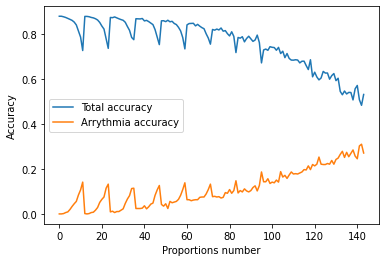

In [ ]:
plt.plot(dane[2], label = "Total accuracy")
plt.plot(dane[3], label = "Arrythmia accuracy")
plt.xlabel("Proportions number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Logistic Regression,\n investigation on weights in the model")

In [ ]:
dane[3].max()

0.3097744360902256

In [ ]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":130, "V":130}, solver='liblinear').fit(new_X_train, y_train)
clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":14, "V":14}, solver='newton-cg').fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Logistic Regression')

-----------------------------------
Logistic Regression
Total accuracy, Acc_T = 0.5178
Arrhythmia accuracy, Acc_A = 0.4060
-----------------------------------


In [ ]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":130, "V":130}, solver='liblinear').fit(new_X_train, y_train)
clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":13, "V":13}, solver='newton-cg').fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Logistic Regression')

-----------------------------------
Logistic Regression
Total accuracy, Acc_T = 0.5985
Arrhythmia accuracy, Acc_A = 0.3414
-----------------------------------


In [ ]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":130, "V":130}, solver='liblinear').fit(new_X_train, y_train)
clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":12, "V":12}, solver='newton-cg').fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Logistic Regression')

-----------------------------------
Logistic Regression
Total accuracy, Acc_T = 0.6440
Arrhythmia accuracy, Acc_A = 0.2902
-----------------------------------


In [ ]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":130, "V":130}, solver='liblinear').fit(new_X_train, y_train)
clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":13, "V":13}, solver='saga').fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Logistic Regression')

-----------------------------------
Logistic Regression
Total accuracy, Acc_T = 0.3407
Arrhythmia accuracy, Acc_A = 0.3564
-----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":130, "V":130}, solver='liblinear').fit(new_X_train, y_train)
clf = LogisticRegression(random_state=0, class_weight = {"N":1.0, "S":12, "V":12}, solver='sag').fit(new_X_train, y_train)
y_pred = clf.predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Logistic Regression')

-----------------------------------
Logistic Regression
Total accuracy, Acc_T = 0.6038
Arrhythmia accuracy, Acc_A = 0.2361
-----------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
new_X_train[0]

array([ 0.449389  , -0.60154298, -0.02450833,  4.56434819,  3.22463618,
        4.02456709,  7.        ,  0.70141178,  4.37519701,  0.96668502,
        4.47214359,  0.61458333,  0.53125   ,  0.04605471,  0.        ])

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tuples = []
for depth in range(2,20):
  dtc = DecisionTreeClassifier(criterion='entropy', 
                             class_weight='balanced', 
                             min_samples_leaf=10, 
                             max_depth=depth)
  y_pred = dtc.fit(new_X_train, y_train).predict(new_X_test)
  y_gt = y_test
  acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
  acc_a = np.count_nonzero(np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
  tuples.append([depth, acc_t, acc_a])

Text(0.5, 1.0, 'Tree depth and accuracy')

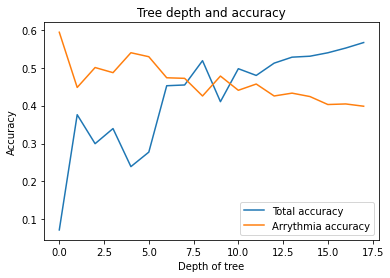

In [ ]:
import matplotlib.pyplot as plt

dane = pd.DataFrame(tuples)
plt.plot(dane[1], label = "Total accuracy")
plt.plot(dane[2], label = "Arrythmia accuracy")
plt.xlabel("Depth of tree")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Tree depth and accuracy")

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=1000, 
                             max_depth=8, 
                             class_weight='balanced')
y_pred = rfc.fit(new_X_train, y_train).predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Random Forest')

-----------------------------------
Random Forest
Total accuracy, Acc_T = 0.5867
Arrhythmia accuracy, Acc_A = 0.4571
-----------------------------------


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', 
                             n_estimators=2000, 
                             max_depth=8, 
                             class_weight='balanced')
y_pred = rfc.fit(new_X_train, y_train).predict(new_X_test)
calculate_accuracy(y_pred, y_test, comment='Random Forest')

-----------------------------------
Random Forest
Total accuracy, Acc_T = 0.5949
Arrhythmia accuracy, Acc_A = 0.4602
-----------------------------------


### Deep Neural Networks

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 16
# learning rate is how fast it will descend
model_args['lr'] = .01 # 0.05 bylo
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 35
# logging frequency
model_args['log_interval'] = 100

### Data oversampling

In [ ]:
dodatkowe = {'S':20000, 'V':20000}
while dodatkowe['S'] >0 or dodatkowe['V']>0:
  for i in range(len(y_train)):
    if  dodatkowe['S'] >0 and y_train[i] =="S":
      new_X_train = np.concatenate((new_X_train, [new_X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['S']-=1
    if  dodatkowe['V'] >0 and y_train[i] =="V":
      new_X_train = np.concatenate((new_X_train, [new_X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['V']-=1

counts = {'N':0, 'S':0, 'V':0}
for i in y_train:
  counts[i]+=1
print(counts)

{'N': 22721, 'S': 21639, 'V': 21358}


In [ ]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
classes = {'N':0,'S':1, 'V':2}
y_train = [classes[i] for i in y_train]
y_val = [classes[i] for i in y_val]
y_test = [classes[i] for i in y_test]

y_train = Tensor(y_train)
y_test = Tensor(y_test)
y_val = Tensor(y_val)

y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)

#y_train = Tensor(y_train)
#y_test = Tensor(y_test)
#y_val = Tensor(y_val)


#X_train.type(torch.LongTensor)
#X_test.type(torch.LongTensor)
#X_val.type(torch.LongTensor)

train_dataset = TensorDataset( Tensor(new_X_train), y_train)
val_dataset = TensorDataset( Tensor(new_X_val), y_val)
test_dataset = TensorDataset( Tensor(new_X_test), y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(val_dataset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **loader_kwargs)

In [ ]:
class Deep(nn.Module):
    # this defines the structure of the Perceptron model
    def __init__(self):
        super(Deep, self).__init__()
        # fully connected layers
        self.conv1= nn.Conv1d(1, 16, kernel_size=3)
        #self.batch1 = nn.BatchNorm1d(8)
        self.conv2 = nn.Conv1d(8, 32, kernel_size=3)
        self.conv3 = nn.Conv1d(16, 64, kernel_size=3)
        self.conv4 = nn.Conv1d(32, 128, kernel_size=3)
        #self.batch2 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(32, 200) #bylo 20
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,20)
        self.fc4 = nn.Linear(20, 3)
        self.dropout = nn.Dropout(0.2) #dodalam

    def forward(self, x):
        x = self.conv1(x)
        #print("size",x.size())
        #x = self.batch1(x)
        #print("size",x.size())
        x = F.max_pool2d(x, 2)
        #print("size",x.size())
        x = F.relu(x)
        x = self.dropout(x)
        #print("size",x.size())
        x = self.conv2(x)
        #x = self.batch2(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.dropout(x)
        #print("size",x.size())
        x = self.conv3(x)
        #print("size",x.size())
        #x = self.batch1(x)
        #print("size",x.size())
        x = F.max_pool2d(x, 2)
        #print("size",x.size())
        x = F.relu(x)
        x = self.dropout(x)
        #print("size",x.size())
        #print("size",x.size())
        #print("size",x.size())
        #hidden
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 736)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        # hidden layer
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        # hidden layer
        #x = self.dropout(x)
        x = self.fc4(x)
        x = self.dropout(x)
        return F.log_softmax(x, dim=1)

In [ ]:
new_X_train[0].shape

(24,)

In [ ]:
X_train[0].shape

(24,)

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deep().to(device)
print(summary(model,(1, 24)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 22]              64
           Dropout-2                [-1, 8, 11]               0
            Conv1d-3                [-1, 32, 9]             800
           Dropout-4                [-1, 16, 4]               0
            Conv1d-5                [-1, 64, 2]           3,136
           Dropout-6                [-1, 32, 1]               0
            Linear-7                  [-1, 200]           6,600
           Dropout-8                  [-1, 200]               0
            Linear-9                  [-1, 100]          20,100
          Dropout-10                  [-1, 100]               0
           Linear-11                   [-1, 20]           2,020
          Dropout-12                   [-1, 20]               0
           Linear-13                    [-1, 3]              63
          Dropout-14                   

In [ ]:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    correct = 0
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        data = data.unsqueeze(1)
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()

        

        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        # moje zeby wypisal accuracy dla arytmii

        train_loss += loss.item()


    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))

    tags = torch.argmax(output, dim=1)
    corrects = (tags !=0).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    print("Training Arytmia acc: ", acc)

    return train_loss
    
def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            data = data.unsqueeze(1)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean') 
            # get the index of class with the max log-probability 
            prediction = output.argmax(dim=1)  
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    tags = torch.argmax(output, dim=1)
    corrects = (tags != 0).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    print("Testing Arytmia acc: ", acc)
    return test_loss

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

Train Epoch: 1 [0/65718 (0%)]	Loss: 1.603261
Train Epoch: 1 [1600/65718 (2%)]	Loss: 1.274027
Train Epoch: 1 [3200/65718 (5%)]	Loss: 1.081590
Train Epoch: 1 [4800/65718 (7%)]	Loss: 1.111465
Train Epoch: 1 [6400/65718 (10%)]	Loss: 1.093320
Train Epoch: 1 [8000/65718 (12%)]	Loss: 1.051635
Train Epoch: 1 [9600/65718 (15%)]	Loss: 1.085185
Train Epoch: 1 [11200/65718 (17%)]	Loss: 1.092814
Train Epoch: 1 [12800/65718 (19%)]	Loss: 1.110569
Train Epoch: 1 [14400/65718 (22%)]	Loss: 1.098180
Train Epoch: 1 [16000/65718 (24%)]	Loss: 1.090632
Train Epoch: 1 [17600/65718 (27%)]	Loss: 1.091554
Train Epoch: 1 [19200/65718 (29%)]	Loss: 1.100896
Train Epoch: 1 [20800/65718 (32%)]	Loss: 1.083760
Train Epoch: 1 [22400/65718 (34%)]	Loss: 1.086663
Train Epoch: 1 [24000/65718 (37%)]	Loss: 1.092414
Train Epoch: 1 [25600/65718 (39%)]	Loss: 1.109357
Train Epoch: 1 [27200/65718 (41%)]	Loss: 1.110491
Train Epoch: 1 [28800/65718 (44%)]	Loss: 1.099467
Train Epoch: 1 [30400/65718 (46%)]	Loss: 1.105602
Train Epoch: 1

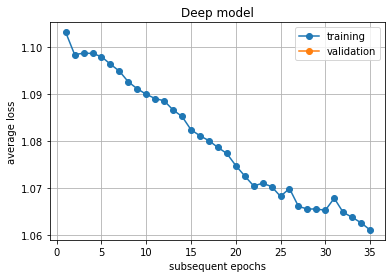

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

In [ ]:
x ={}
y = y_train.numpy()
for i in y:
  if i not in x.keys():
    x[i]=0
  else:
    x[i]+=1
print(x)

{0: 22720, 1: 21638, 2: 21357}


In [ ]:
nb_classes = 3
DEVICE =device
import numpy as np
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

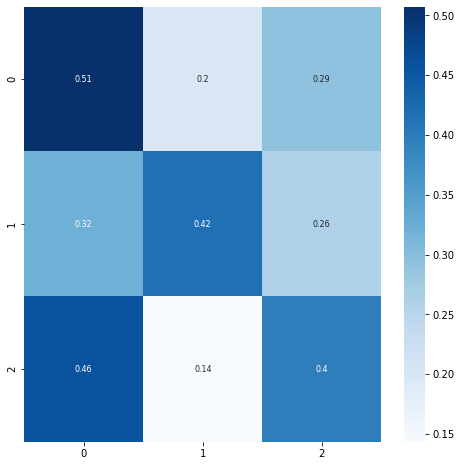

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
new_matrix = [[] for row in confusion_matrix]
i=0
for row in confusion_matrix:
  for j in row:
    new_matrix[i].append(j/sum(row))
  i+=1
  
plt.figure(figsize =(8,8))
sns.heatmap(new_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":8})

Poor accuracy let s check other epochs and batches

### Stopping earlier

Train Epoch: 1 [0/65718 (0%)]	Loss: 1.148617
Train Epoch: 1 [1600/65718 (2%)]	Loss: 1.119977
Train Epoch: 1 [3200/65718 (5%)]	Loss: 1.100109
Train Epoch: 1 [4800/65718 (7%)]	Loss: 1.106084
Train Epoch: 1 [6400/65718 (10%)]	Loss: 1.087170
Train Epoch: 1 [8000/65718 (12%)]	Loss: 1.045756
Train Epoch: 1 [9600/65718 (15%)]	Loss: 1.085881
Train Epoch: 1 [11200/65718 (17%)]	Loss: 1.092726
Train Epoch: 1 [12800/65718 (19%)]	Loss: 1.126052
Train Epoch: 1 [14400/65718 (22%)]	Loss: 1.074916
Train Epoch: 1 [16000/65718 (24%)]	Loss: 1.072182
Train Epoch: 1 [17600/65718 (27%)]	Loss: 1.082385
Train Epoch: 1 [19200/65718 (29%)]	Loss: 1.101047
Train Epoch: 1 [20800/65718 (32%)]	Loss: 1.083290
Train Epoch: 1 [22400/65718 (34%)]	Loss: 1.088015
Train Epoch: 1 [24000/65718 (37%)]	Loss: 1.090282
Train Epoch: 1 [25600/65718 (39%)]	Loss: 1.110713
Train Epoch: 1 [27200/65718 (41%)]	Loss: 1.110369
Train Epoch: 1 [28800/65718 (44%)]	Loss: 1.099195
Train Epoch: 1 [30400/65718 (46%)]	Loss: 1.105930
Train Epoch: 1

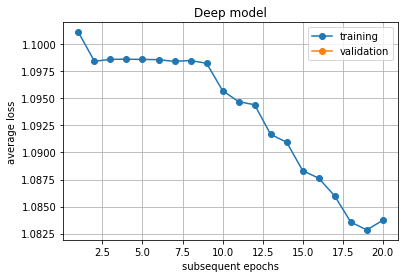

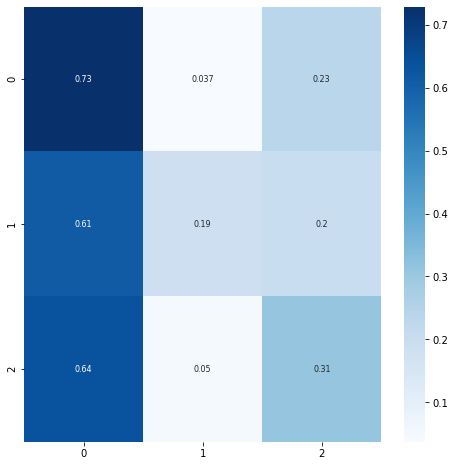

In [ ]:
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 16
# learning rate is how fast it will descend
model_args['lr'] = .01 # 0.05 bylo
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 20
# logging frequency
model_args['log_interval'] = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

nb_classes = 3
DEVICE =device
import numpy as np
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

new_matrix = [[] for row in confusion_matrix]
i=0
for row in confusion_matrix:
  for j in row:
    new_matrix[i].append(j/sum(row))
  i+=1
  
plt.figure(figsize =(8,8))
sns.heatmap(new_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":8})

### Stopping later




Train Epoch: 1 [0/65718 (0%)]	Loss: 1.089834
Train Epoch: 1 [1600/65718 (2%)]	Loss: 1.102615
Train Epoch: 1 [3200/65718 (5%)]	Loss: 1.082417
Train Epoch: 1 [4800/65718 (7%)]	Loss: 1.101897
Train Epoch: 1 [6400/65718 (10%)]	Loss: 1.091344
Train Epoch: 1 [8000/65718 (12%)]	Loss: 1.061992
Train Epoch: 1 [9600/65718 (15%)]	Loss: 1.087172
Train Epoch: 1 [11200/65718 (17%)]	Loss: 1.093415
Train Epoch: 1 [12800/65718 (19%)]	Loss: 1.111957
Train Epoch: 1 [14400/65718 (22%)]	Loss: 1.098140
Train Epoch: 1 [16000/65718 (24%)]	Loss: 1.085264
Train Epoch: 1 [17600/65718 (27%)]	Loss: 1.095399
Train Epoch: 1 [19200/65718 (29%)]	Loss: 1.104461
Train Epoch: 1 [20800/65718 (32%)]	Loss: 1.082638
Train Epoch: 1 [22400/65718 (34%)]	Loss: 1.087379
Train Epoch: 1 [24000/65718 (37%)]	Loss: 1.091552
Train Epoch: 1 [25600/65718 (39%)]	Loss: 1.111700
Train Epoch: 1 [27200/65718 (41%)]	Loss: 1.110385
Train Epoch: 1 [28800/65718 (44%)]	Loss: 1.098801
Train Epoch: 1 [30400/65718 (46%)]	Loss: 1.105318
Train Epoch: 1

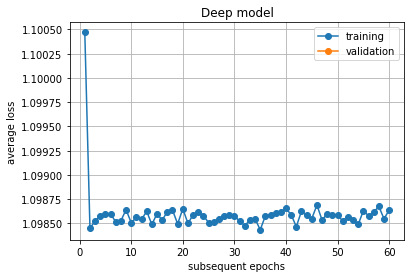

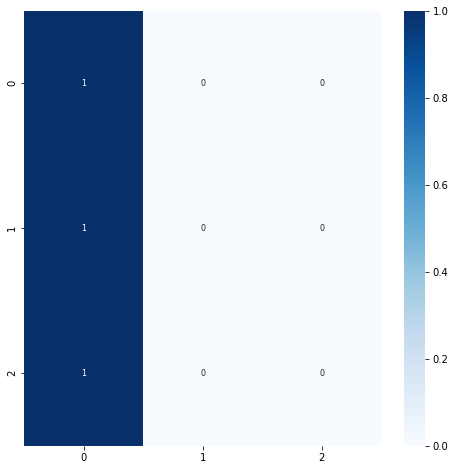

In [ ]:
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 16
# learning rate is how fast it will descend
model_args['lr'] = .01 # 0.05 bylo
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 60
# logging frequency
model_args['log_interval'] = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

nb_classes = 3
DEVICE =device
import numpy as np
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

new_matrix = [[] for row in confusion_matrix]
i=0
for row in confusion_matrix:
  for j in row:
    new_matrix[i].append(j/sum(row))
  i+=1
  
plt.figure(figsize =(8,8))
sns.heatmap(new_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":8})

Too ealry or too quick stopping causes the dominance of one class when classifying.

# Feature extraction + the data itself

In [8]:
def features_vector_creation(X):
  feature_vector = []
  for i in X:
    maxi = i.max()
    mini = i.min()
    med = np.median(i)

    p_data = pd.DataFrame(i).value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data) 

    E = np.sum(i ** 2)
    Xk = np.fft.fft(i)
    N = len(i)
    E_fft = np.sum(np.abs(Xk) ** 2) / N

    shannon = ent.spectral_entropy(i, sf=100, method='welch')

    zero_cross = ent.num_zerocross(i)

    svd_entropy = ent.svd_entropy(i, order=2)

    sum = tsfresh.feature_extraction.feature_calculators.absolute_sum_of_changes(i)
    #auto = tsfresh.feature_extraction.feature_calculators.agg_autocorrelation(i, 5)
    ben = tsfresh.feature_extraction.feature_calculators.benford_correlation(i)
    cid = tsfresh.feature_extraction.feature_calculators.cid_ce(i, normalize=True)
    first1 = tsfresh.feature_extraction.feature_calculators.first_location_of_maximum(i)
    first2 = tsfresh.feature_extraction.feature_calculators.first_location_of_minimum(i)
    mean_abs = tsfresh.feature_extraction.feature_calculators.mean_abs_change(i)
    perc = tsfresh.feature_extraction.feature_calculators.percentage_of_reoccurring_datapoints_to_all_datapoints(i)
    strike1 = tsfresh.feature_extraction.feature_calculators.longest_strike_below_mean(i)
    strike2 = tsfresh.feature_extraction.feature_calculators.longest_strike_above_mean(i)
    duplicate1 = tsfresh.feature_extraction.feature_calculators.has_duplicate_max(i)
    duplicate2 = tsfresh.feature_extraction.feature_calculators.has_duplicate_min(i)
    kurtosis = tsfresh.feature_extraction.feature_calculators.kurtosis(i)
    der = tsfresh.feature_extraction.feature_calculators.mean_second_derivative_central(i)
    rms = tsfresh.feature_extraction.feature_calculators.root_mean_square(i)
    skewness = tsfresh.feature_extraction.feature_calculators.skewness(i)
    
    vector = np.array([maxi, mini, med, entropy, E_fft, shannon, zero_cross, svd_entropy, der,
                                    sum, ben, cid, first1, first2, mean_abs, perc, strike1, strike2, duplicate1, duplicate2, kurtosis,
                                    der, rms, skewness])

    feature_vector.append((vector,i))
  return np.array(feature_vector)

In [35]:
new_X_train = features_vector_creation(X_train)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

In [36]:
new_X_test = features_vector_creation(X_test)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

In [37]:
new_X_val = features_vector_creation(X_val)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1963: UserWarning: nperseg = 256 is greater than input length  = 96, using nperseg = 96
  .format(nperseg, input_length))
/usr/

In [41]:
new_X_train[0]

array([ 1.33496837e+00, -2.00180435e+00, -1.05644398e-01,  4.56434819e+00,
        6.40210081e+01,  2.68628390e+00,  5.00000000e+00,  4.74026580e-01,
        4.27420196e-04,  1.02496512e+01,  9.56472895e-01,  2.20335562e+00,
        7.08333333e-01,  4.68750000e-01,  1.07891065e-01,  0.00000000e+00,
        2.20000000e+01,  3.90000000e+01,  0.00000000e+00,  0.00000000e+00,
       -1.18804678e-01,  4.27420196e-04,  8.16630578e-01, -3.25831414e-01])

In [38]:
dodatkowe = {'S':20000, 'V':20000}
while dodatkowe['S'] >0 or dodatkowe['V']>0:
  for i in range(len(y_train)):
    if  dodatkowe['S'] >0 and y_train[i] =="S":
      new_X_train = np.concatenate((new_X_train, [new_X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['S']-=1
    if  dodatkowe['V'] >0 and y_train[i] =="V":
      new_X_train = np.concatenate((new_X_train, [new_X_train[i]]), axis=0)
      y_train = np.concatenate((y_train, [y_train[i]]))
      dodatkowe['V']-=1

counts = {'N':0, 'S':0, 'V':0}
for i in y_train:
  counts[i]+=1
print(counts)

{'N': 22635, 'S': 21723, 'V': 21360}


In [39]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
classes = {'N':0,'S':1, 'V':2}
y_train = [classes[i] for i in y_train]
y_val = [classes[i] for i in y_val]
y_test = [classes[i] for i in y_test]

y_train = Tensor(y_train)
y_test = Tensor(y_test)
y_val = Tensor(y_val)

y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)

#train_dataset = TensorDataset( Tensor(new_X_train), y_train)
train_dataset = TensorDataset( torch.from_numpy(new_X_train), y_train)
val_dataset = TensorDataset( torch.from_numpy(new_X_val), y_val)
test_dataset = TensorDataset( torch.from_numpy(new_X_test), y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(val_dataset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **loader_kwargs)

In [31]:
new_X_train[0]

array([array([ 1.33496837e+00, -2.00180435e+00, -1.05644398e-01,  4.56434819e+00,
        6.40210081e+01,  2.68628390e+00,  5.00000000e+00,  4.74026580e-01,
        4.27420196e-04,  1.02496512e+01,  9.56472895e-01,  2.20335562e+00,
        7.08333333e-01,  4.68750000e-01,  1.07891065e-01,  0.00000000e+00,
        2.20000000e+01,  3.90000000e+01,  0.00000000e+00,  0.00000000e+00,
       -1.18804678e-01,  4.27420196e-04,  8.16630578e-01, -3.25831414e-01]),
       array([-0.06069942, -0.10368212, -0.09515057, -0.1433247 , -0.11610719,
       -0.10995436, -0.10640123, -0.1352373 , -0.15184509, -0.20904399,
       -0.17318914, -0.22465949, -0.23411619, -0.29202953, -0.26699783,
       -0.24592613, -0.19354588, -0.07708047,  0.03286485, -0.0642297 ,
       -0.27870048, -0.33001426, -0.39873793, -0.3671114 , -0.24490709,
       -0.13671267, -0.2897774 , -0.45317848, -0.65366214, -0.67359435,
       -0.65274119, -0.6175173 , -0.52543147, -0.44448735, -0.41058004,
       -0.38799507, -0.2858281

Train Epoch: 1 [0/65718 (0%)]	Loss: 1.228365
Train Epoch: 1 [1600/65718 (2%)]	Loss: 1.081002
Train Epoch: 1 [3200/65718 (5%)]	Loss: 1.095062
Train Epoch: 1 [4800/65718 (7%)]	Loss: 1.107028
Train Epoch: 1 [6400/65718 (10%)]	Loss: 1.094062
Train Epoch: 1 [8000/65718 (12%)]	Loss: 1.058380
Train Epoch: 1 [9600/65718 (15%)]	Loss: 1.086797
Train Epoch: 1 [11200/65718 (17%)]	Loss: 1.096276
Train Epoch: 1 [12800/65718 (19%)]	Loss: 1.111474
Train Epoch: 1 [14400/65718 (22%)]	Loss: 1.097732
Train Epoch: 1 [16000/65718 (24%)]	Loss: 1.088832
Train Epoch: 1 [17600/65718 (27%)]	Loss: 1.092217
Train Epoch: 1 [19200/65718 (29%)]	Loss: 1.101580
Train Epoch: 1 [20800/65718 (32%)]	Loss: 1.082442
Train Epoch: 1 [22400/65718 (34%)]	Loss: 1.087067
Train Epoch: 1 [24000/65718 (37%)]	Loss: 1.091817
Train Epoch: 1 [25600/65718 (39%)]	Loss: 1.108945
Train Epoch: 1 [27200/65718 (41%)]	Loss: 1.110550
Train Epoch: 1 [28800/65718 (44%)]	Loss: 1.098606
Train Epoch: 1 [30400/65718 (46%)]	Loss: 1.105656
Train Epoch: 1

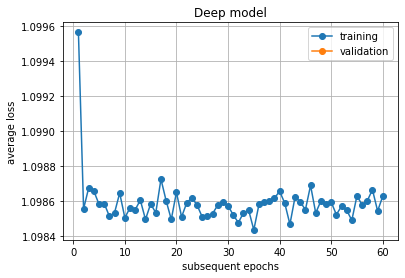

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03adcad680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f03adcad680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

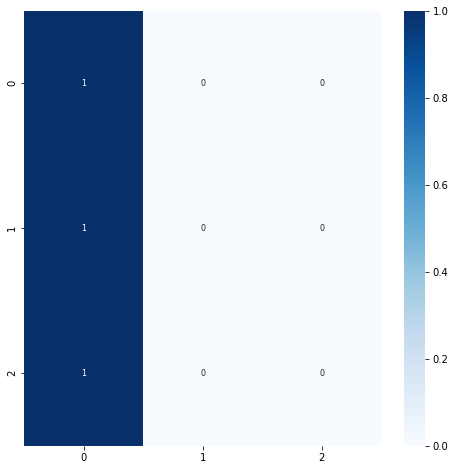

In [ ]:
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 16
# learning rate is how fast it will descend
model_args['lr'] = .01 # 0.05 bylo
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 60
# logging frequency
model_args['log_interval'] = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'])
                      #weight_decay=1.e-3)
#optimizer = optim.Adadelta(model.parameters(), lr=model_args['lr'])

torch.manual_seed(model_args['seed'])
train_loss = []
validation_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch_number))
    validation_loss.append(test(model, device, validation_loader, 'Validation set'))

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'Deep model')

nb_classes = 3
DEVICE =device
import numpy as np
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        inputs = inputs.unsqueeze(1)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

new_matrix = [[] for row in confusion_matrix]
i=0
for row in confusion_matrix:
  for j in row:
    new_matrix[i].append(j/sum(row))
  i+=1
  
plt.figure(figsize =(8,8))
sns.heatmap(new_matrix, annot=True, cmap="Blues", annot_kws={"fontsize":8})

Frequently denies to learn, maybe different structure of the network?